# Домашнее задание: Классификация SVM (Support Vector Machine)

## 1. Загрузка данных и предварительный анализ

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
import joblib

# Загрузка данных
train_df = pd.read_csv("train_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

# Определение целевой переменной
target_col = "smoking"

# Разделение на признаки и целевую переменную
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

# Удаляем целевую переменную, если она есть в test.csv
X_test = test_df.drop(columns=[target_col], errors='ignore')

# Проверка структуры данных
print("Train dataset info:")
print(train_df.info())

print("\nTest dataset info:")
print(test_df.info())


Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38984 entries, 0 to 38983
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  38984 non-null  int64  
 1   height(cm)           38984 non-null  int64  
 2   weight(kg)           38984 non-null  int64  
 3   waist(cm)            38984 non-null  float64
 4   eyesight(left)       38984 non-null  float64
 5   eyesight(right)      38984 non-null  float64
 6   hearing(left)        38984 non-null  int64  
 7   hearing(right)       38984 non-null  int64  
 8   systolic             38984 non-null  int64  
 9   relaxation           38984 non-null  int64  
 10  fasting blood sugar  38984 non-null  int64  
 11  Cholesterol          38984 non-null  int64  
 12  triglyceride         38984 non-null  int64  
 13  HDL                  38984 non-null  int64  
 14  LDL                  38984 non-null  int64  
 15  hemoglobin      

## 2. EDA (Exploratory Data Analysis)

Доля пропусков в train dataset:
Series([], dtype: float64)

Статистика по числовым признакам:
                age    height(cm)    weight(kg)     waist(cm)  eyesight(left)  \
count  38984.000000  38984.000000  38984.000000  38984.000000    38984.000000   
mean      44.127591    164.689488     65.938718     82.062115        1.014955   
std       12.063564      9.187507     12.896581      9.326798        0.498527   
min       20.000000    130.000000     30.000000     51.000000        0.100000   
10%       30.000000    150.000000     50.000000     70.000000        0.600000   
25%       40.000000    160.000000     55.000000     76.000000        0.800000   
50%       40.000000    165.000000     65.000000     82.000000        1.000000   
75%       55.000000    170.000000     75.000000     88.000000        1.200000   
90%       60.000000    175.000000     85.000000     94.000000        1.500000   
max       85.000000    190.000000    135.000000    129.000000        9.900000   

       eyesigh

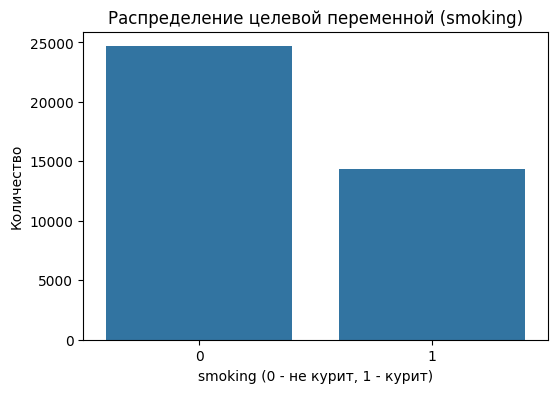

In [2]:

# Доля пропусков
missing_values = train_df.isnull().sum() / len(train_df) * 100
print("Доля пропусков в train dataset:")
print(missing_values[missing_values > 0])

# Статистические характеристики
print("\nСтатистика по числовым признакам:")
print(train_df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

# Доля 1 в целевой переменной
print(f"Доля курильщиков (smoking=1): {train_df[target_col].mean():.2%}")

# Визуализация целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df[target_col])
plt.title("Распределение целевой переменной (smoking)")
plt.xlabel("smoking (0 - не курит, 1 - курит)")
plt.ylabel("Количество")
plt.show()


## 3. Визуализация данных

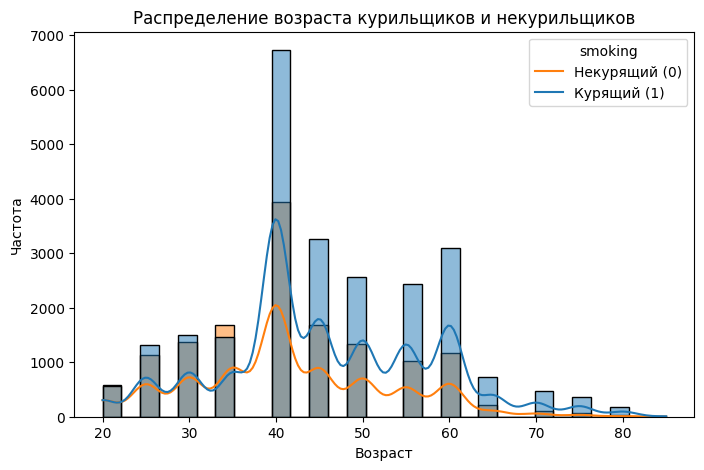

In [3]:

# Гистограмма распределения возраста курильщиков и некурильщиков
plt.figure(figsize=(8, 5))
sns.histplot(data=train_df, x="age", hue="smoking", kde=True, bins=30, alpha=0.5)
plt.title("Распределение возраста курильщиков и некурильщиков")
plt.xlabel("Возраст")
plt.ylabel("Частота")
plt.legend(title="smoking", labels=["Некурящий (0)", "Курящий (1)"])
plt.show()


## 4. Предобработка данных

In [4]:

# Определяем числовые и категориальные признаки
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns

# Создаем трансформеры для обработки
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Заполняем NaN медианой
    ("scaler", StandardScaler())  # Масштабируем числовые признаки
])

categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # Кодируем категориальные признаки
])

# Объединяем в `ColumnTransformer`
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Применяем преобразования
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("Предобработка данных завершена.")


Предобработка данных завершена.


## 5. Обучение модели SVM (SVC)

In [5]:

# Обучение SVC (Support Vector Classification)
svc_model = SVC(kernel="linear", C=1.0, probability=True)
svc_model.fit(X_train_processed, y_train)

# Предсказание
y_train_pred_svc = svc_model.predict(X_train_processed)


## 6. Оценка качества модели

Accuracy: 0.7294
Precision: 0.6387
Recall: 0.6057
F1 Score: 0.6218
ROC AUC: 0.8105


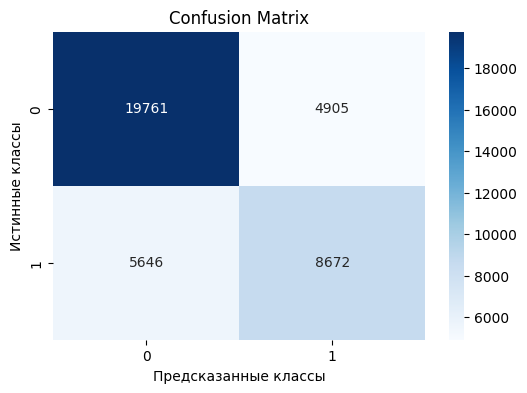

In [6]:

# Метрики качества
accuracy = accuracy_score(y_train, y_train_pred_svc)
precision = precision_score(y_train, y_train_pred_svc)
recall = recall_score(y_train, y_train_pred_svc)
f1 = f1_score(y_train, y_train_pred_svc)
roc_auc = roc_auc_score(y_train, svc_model.predict_proba(X_train_processed)[:, 1])

# Вывод результатов
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_train, y_train_pred_svc), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Confusion Matrix")
plt.show()


## 7. Подбор гиперпараметров (GridSearchCV)

In [7]:

# Оптимизация SVM
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"]
}

grid_search_svc = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_svc.fit(X_train_processed, y_train)

# Лучшие параметры
best_svc_model = grid_search_svc.best_estimator_
print("Лучшие параметры для SVC:", grid_search_svc.best_params_)

# Оценка качества после подбора параметров
y_train_pred_best_svc = best_svc_model.predict(X_train_processed)
print("Классификационный отчет после оптимизации:")
print(classification_report(y_train, y_train_pred_best_svc))


KeyboardInterrupt: 

## 8. Сохранение модели и предсказаний

In [ ]:

# Сохранение модели
joblib.dump(best_svc_model, "svc_best_model.joblib")

# Предсказание на тесте
y_test_pred = best_svc_model.predict(X_test_processed)

# Сохранение предсказаний
test_predictions = pd.DataFrame({"Prediction": y_test_pred})
test_predictions.to_csv("test_predictions.csv", index=False)
print("Предсказания сохранены в 'test_predictions.csv'")
